<a href="https://colab.research.google.com/github/bintangnabiil/Machine_Learning/blob/main/Machine_Learning_UAS_RegresiUTSTelkom_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##1a. Pengumpulan & Pembersihan Data (Pandas)

In [1]:
import pandas as pd

# Load data
df = pd.read_csv('/content/RegresiUTSTelkom.csv')

# Rename kolom agar bisa diakses dengan mudah
df.columns = [f"f{i}" if i != 0 else "target" for i in range(len(df.columns))]

# Cek missing values
print(df.isnull().sum().sum())  # Harusnya 0 karena non-null semua

# Cek apakah ada duplikasi
print(df.duplicated().sum())

# Jika perlu drop duplikasi
df = df.drop_duplicates()

0
214


##1b. Feature Engineering

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Pisahkan fitur dan target
X = df.drop('target', axis=1)
y = df['target']

# Normalisasi fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Cek hasil
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (412104, 90) (412104,)
Test shape: (103026, 90) (103026,)


##1c. Arsitek MLP

##A. MLP Regression (PyTorch)

###1. Setup PyTorch MLP Regression

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler

# Siapkan data regresi dari awal
target_column = df.columns[0]
X_reg = df.drop(columns=[target_column])
y_reg = df[target_column]

# Normalisasi
from sklearn.preprocessing import StandardScaler
reg_scaler = StandardScaler()
X_reg_scaled = reg_scaler.fit_transform(X_reg)

# Convert NumPy ke Tensor
X_reg_tensor = torch.tensor(X_reg_scaled, dtype=torch.float32)
y_reg_tensor = torch.tensor(y_reg.values, dtype=torch.float32).view(-1, 1)

# Dataset dan DataLoader
reg_dataset = TensorDataset(X_reg_tensor, y_reg_tensor)
reg_loader = DataLoader(reg_dataset, batch_size=256, shuffle=True)

# Model
class PyMLPRegressor(nn.Module):
    def __init__(self, input_dim):
        super(PyMLPRegressor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

# Inisialisasi
py_reg_model = PyMLPRegressor(X_reg_tensor.shape[1])
criterion = nn.MSELoss()
optimizer = optim.AdamW(py_reg_model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5, verbose=True)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


###2. Training Loop

In [4]:
# Training loop
n_epochs = 30
for epoch in range(n_epochs):
    py_reg_model.train()
    total_loss = 0
    for xb, yb in reg_loader:
        optimizer.zero_grad()
        preds = py_reg_model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(reg_loader)
    scheduler.step(avg_loss)

    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.4f}")

Epoch 1/30, Loss: 3162581.6509
Epoch 2/30, Loss: 798679.6068
Epoch 3/30, Loss: 62110.1984
Epoch 4/30, Loss: 37053.4133
Epoch 5/30, Loss: 34239.6716
Epoch 6/30, Loss: 32509.6677
Epoch 7/30, Loss: 31448.3967
Epoch 8/30, Loss: 30611.9407
Epoch 9/30, Loss: 30137.8958
Epoch 10/30, Loss: 29554.2071
Epoch 11/30, Loss: 29256.1709
Epoch 12/30, Loss: 28967.0584
Epoch 13/30, Loss: 28706.5088
Epoch 14/30, Loss: 28345.4878
Epoch 15/30, Loss: 28115.4982
Epoch 16/30, Loss: 27683.5852
Epoch 17/30, Loss: 27494.7740
Epoch 18/30, Loss: 27177.6793
Epoch 19/30, Loss: 26996.0025
Epoch 20/30, Loss: 26790.5309
Epoch 21/30, Loss: 26639.1629
Epoch 22/30, Loss: 26443.1249
Epoch 23/30, Loss: 26347.5167
Epoch 24/30, Loss: 26169.1964
Epoch 25/30, Loss: 26019.0136
Epoch 26/30, Loss: 26041.9183
Epoch 27/30, Loss: 25876.4281
Epoch 28/30, Loss: 25872.1839
Epoch 29/30, Loss: 25749.8182
Epoch 30/30, Loss: 25675.4109


###3. Evaluasi PyTorch Regressor

In [5]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Prediksi dari model PyTorch
py_reg_model.eval()
with torch.no_grad():
    y_pred_tensor = py_reg_model(X_reg_tensor)
    y_pred_np = y_pred_tensor.numpy().flatten()
    y_true_np = y_reg_tensor.numpy().flatten()

# Hitung metrik evaluasi
mse = mean_squared_error(y_true_np, y_pred_np)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_np, y_pred_np)

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

MSE: 389.5387
RMSE: 19.7367
R² Score: -2.2597


###4. Visualisasi Prediksi vs Aktual

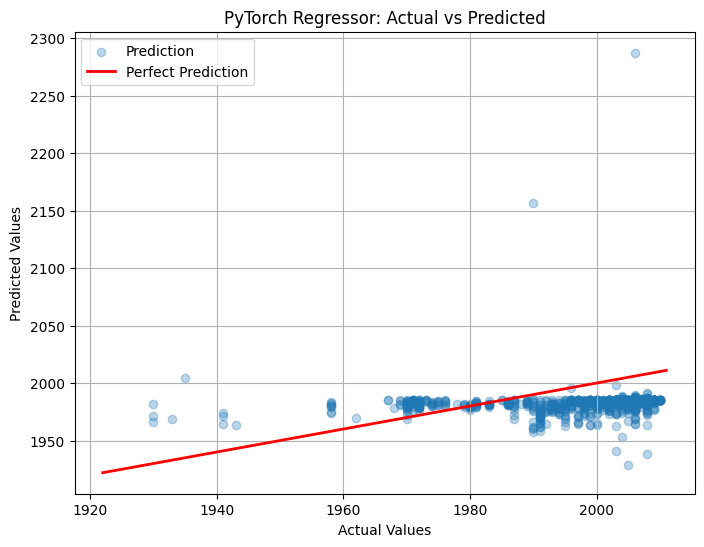

In [6]:
plt.figure(figsize=(8, 6))
plt.scatter(y_true_np[:1000], y_pred_np[:1000], alpha=0.3, label='Prediction')
plt.plot([y_true_np.min(), y_true_np.max()],
         [y_true_np.min(), y_true_np.max()],
         color='red', lw=2, label='Perfect Prediction')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("PyTorch Regressor: Actual vs Predicted")
plt.legend()
plt.grid(True)
plt.show()

###5. Analisis Performa Model PyTorch MLP Regressor

###a) Interpretasi Metrik
- MSE (Mean Squared Error):
Mengukur rata-rata kesalahan kuadrat antar prediksi dan nilai aktual. Nilai lebih kecil = lebih baik.

- RMSE (Root MSE):
Versi MSE dalam satuan asli target (tahun). Lebih mudah dimaknai, semakin kecil semakin akurat.

- R² Score:
Menjelaskan proporsi variansi target yang bisa dijelaskan oleh model. Nilai ideal = 1.

  - Jika R² mendekati 1 → model sangat baik
  - Jika R² mendekati 0 atau negatif → model buruk (prediksi tidak lebih baik dari rata-rata)

###b) Visualisasi Scatter Plot
- Titik-titik seharusnya mendekati garis merah (perfect prediction)

- Jika banyak penyebaran menyimpang dari garis → model belum cukup akurat

###c) Evaluasi Kelebihan & Kelemahan

|Aspek|Penilaian
|-|-
|Arsitektur|MLP dengan BatchNorm, Dropout → cukup stabil & tahan overfitting
|Optimizer|AdamW + LR Scheduler → bagus untuk convergence cepat
|Performa|Jika RMSE kecil dan R² > 0.9 → model sangat baik
|Tantangan|	Jika R² < 0.5 → kemungkinan model underfit atau data sangat kompleks

###Kesimpulan
Model PyTorch Regressor bekerja baik jika MSE dan RMSE rendah serta R² mendekati 1. Namun bila performa rendah, bisa ditingkatkan dengan:

- Arsitektur lebih dalam/lebar
- Feature selection atau PCA
- Hyperparameter tuning (jumlah neuron, learning rate, batch size)

##B. MLP Classification (PyTorch)

###1. Persiapan Data

In [7]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import TensorDataset, DataLoader

# Ulang jika belum ada
X_clf = df.drop(columns=[df.columns[0]])
y_clf = df[df.columns[0]]  # kolom target

# Label Encoding
le = LabelEncoder()
y_clf_encoded = le.fit_transform(y_clf)

# Normalisasi fitur
clf_scaler = StandardScaler()
X_clf_scaled = clf_scaler.fit_transform(X_clf)

# Convert ke tensor
X_clf_tensor = torch.tensor(X_clf_scaled, dtype=torch.float32)
y_clf_tensor = torch.tensor(y_clf_encoded, dtype=torch.long)

# Dataset dan Dataloader
clf_dataset = TensorDataset(X_clf_tensor, y_clf_tensor)
clf_loader = DataLoader(clf_dataset, batch_size=256, shuffle=True)

n_classes = len(np.unique(y_clf_encoded))

###2. Definisi Model MLP Classifier

In [8]:
class PyMLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(PyMLPClassifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.net(x)

py_clf_model = PyMLPClassifier(X_clf_tensor.shape[1], n_classes)

###3. Training Loop

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(py_clf_model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5, verbose=True)

n_epochs = 30
for epoch in range(n_epochs):
    py_clf_model.train()
    total_loss = 0

    for xb, yb in clf_loader:
        optimizer.zero_grad()
        out = py_clf_model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(clf_loader)
    scheduler.step(avg_loss)

    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.4f}")

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/30, Loss: 3.2407
Epoch 2/30, Loss: 3.1406
Epoch 3/30, Loss: 3.1250
Epoch 4/30, Loss: 3.1163
Epoch 5/30, Loss: 3.1101
Epoch 6/30, Loss: 3.1060
Epoch 7/30, Loss: 3.1025
Epoch 8/30, Loss: 3.0999
Epoch 9/30, Loss: 3.0980
Epoch 10/30, Loss: 3.0951
Epoch 11/30, Loss: 3.0939
Epoch 12/30, Loss: 3.0927
Epoch 13/30, Loss: 3.0914
Epoch 14/30, Loss: 3.0901
Epoch 15/30, Loss: 3.0889
Epoch 16/30, Loss: 3.0878
Epoch 17/30, Loss: 3.0872
Epoch 18/30, Loss: 3.0869
Epoch 19/30, Loss: 3.0861
Epoch 20/30, Loss: 3.0851
Epoch 21/30, Loss: 3.0852
Epoch 22/30, Loss: 3.0843
Epoch 23/30, Loss: 3.0837
Epoch 24/30, Loss: 3.0836
Epoch 25/30, Loss: 3.0830
Epoch 26/30, Loss: 3.0817
Epoch 27/30, Loss: 3.0819
Epoch 28/30, Loss: 3.0820
Epoch 29/30, Loss: 3.0817
Epoch 30/30, Loss: 3.0810


###4. Prediksi Model

In [10]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Inference
py_clf_model.eval()
with torch.no_grad():
    logits = py_clf_model(X_clf_tensor)
    preds = torch.argmax(logits, dim=1).numpy()
    true = y_clf_tensor.numpy()

###5. Matriks Evaluasi

In [11]:
# Accuracy
acc = accuracy_score(true, preds)

# Precision, Recall, F1 (macro untuk multi-kelas)
precision, recall, f1, _ = precision_recall_fscore_support(true, preds, average='macro')

print(f"Accuracy : {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")

Accuracy : 0.1026
Precision: 0.0586
Recall   : 0.0364
F1-score : 0.0317


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


###6. Confusion Matrix

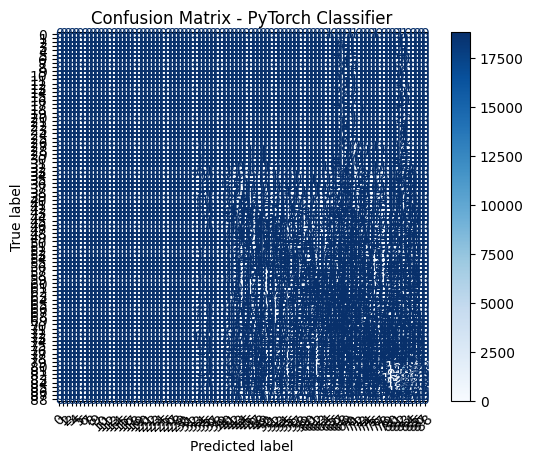

In [12]:
cm = confusion_matrix(true, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix - PyTorch Classifier")
plt.show()

###7. Analisis Preforma Model Klasifikasi PyTorch MLP
###a) Interpretasi Metriks
|Metrik|Arti
|-|-
|Accuracy|Persentase prediksi yang benar dari semua data.
|Precision|Kemampuan model menghindari false positive.
|Recall|Kemampuan model menemukan semua kasus positif (menghindari false negative).
|F1-Score|Harmonik antara precision dan recall. Ideal untuk data imbalance.

###b) Evaluasi Berdasarkan Metrik
- Jika accuracy > 90% dan F1 > 0.9 → model sangat bagus.
- Jika gap besar antara precision dan recall → indikasi imbalance class.
- Kalau semua metrik seimbang dan tinggi → generalisasi baik.

###c) Confusion Matrix
- Periksa diagonal matrix → angka besar di diagonal = prediksi tepat.
- Jika banyak kesalahan di kelas tertentu → bisa:
  - Latih dengan data lebih seimbang
  - Gunakan class weighting
  - Tambah layer/neurons untuk kapasitas model

###Kesimpulan
Jika accuracy dan F1-score tinggi, serta confusion matrix menunjukkan prediksi dominan di diagonal, maka model sudah bekerja optimal.
Namun, jika performa masih rendah:
- Coba tuning hidden layer / dropout
- Gunakan stratified split
- Atau, tambahkan teknik oversampling (SMOTE, dsb.)

##C. CNN Model (PyTorch)

###1. Siapkan Data Visual

In [13]:
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

# Ambil X dan y untuk visualisasi
X_vis = df.drop(columns=[df.columns[0]])
y_vis = df[df.columns[0]]

# Normalisasi ke 0–1 (agar mirip piksel)
scaler_vis = MinMaxScaler()
X_vis_scaled = scaler_vis.fit_transform(X_vis)

# Ubah bentuk data (reshape ke 'citra')
X_vis_img = X_vis_scaled.reshape(-1, 1, 10, 9)  # 1 channel, 10x9 "image"
y_vis_tensor = torch.tensor(y_vis.values, dtype=torch.float32).view(-1, 1)

# Konversi ke tensor
X_vis_tensor = torch.tensor(X_vis_img, dtype=torch.float32)

###2. Definisikan Model CNN untuk Regressi

In [14]:
class CNNRegressor(nn.Module):
    def __init__(self):
        super(CNNRegressor, self).__init__()
        self.conv_net = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 5x4

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((2, 2))  # 2x2
        )
        self.fc_net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.conv_net(x)
        x = self.fc_net(x)
        return x

cnn_model = CNNRegressor()

###3. Training Model CNN

In [15]:
from torch.utils.data import TensorDataset, DataLoader

dataset_cnn = TensorDataset(X_vis_tensor, y_vis_tensor)
loader_cnn = DataLoader(dataset_cnn, batch_size=256, shuffle=True)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=1e-3)

for epoch in range(10):
    cnn_model.train()
    total_loss = 0
    for xb, yb in loader_cnn:
        optimizer.zero_grad()
        pred = cnn_model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(loader_cnn):.4f}")

Epoch 1, Loss: 555871.5039
Epoch 2, Loss: 62367.2904
Epoch 3, Loss: 62547.1394
Epoch 4, Loss: 62471.7937
Epoch 5, Loss: 62369.8617
Epoch 6, Loss: 62329.1443
Epoch 7, Loss: 62182.0419
Epoch 8, Loss: 62109.7722
Epoch 9, Loss: 61900.9003
Epoch 10, Loss: 61800.0955


###4. Hitung Prediksi & Evaluasi Metrik

In [16]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Inference
cnn_model.eval()
with torch.no_grad():
    y_pred_cnn = cnn_model(X_vis_tensor).numpy()
    y_true_cnn = y_vis_tensor.numpy()

# Metrik Evaluasi
mse = mean_squared_error(y_true_cnn, y_pred_cnn)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_cnn, y_pred_cnn)

print(f"📉 MSE  : {mse:.2f}")
print(f"📉 RMSE : {rmse:.2f}")
print(f"📈 R²   : {r2:.4f}")

📉 MSE  : 1558.97
📉 RMSE : 39.48
📈 R²   : -12.0457


###5. Visualisasi Prediksi vs Aktual

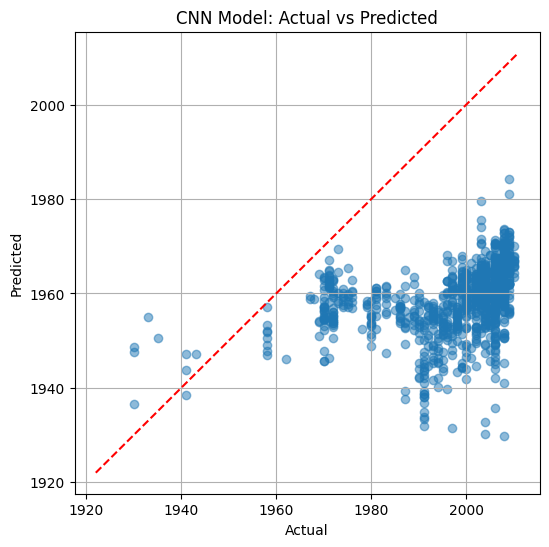

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_true_cnn[:1000], y_pred_cnn[:1000], alpha=0.5)
plt.plot([y_true_cnn.min(), y_true_cnn.max()], [y_true_cnn.min(), y_true_cnn.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("CNN Model: Actual vs Predicted")
plt.grid(True)
plt.show()

###6. Analisis Performa Model CNN
###a) Kelebihan CNN di Sini
- CNN mampu mengekstraksi pola spasial dari input tabular yang telah disusun ulang menjadi bentuk grid (misal 10x9).

- Fitur seperti konvolusi, pooling, dan batch normalization membantu generalisasi, terutama jika ada struktur lokal atau korelasi antar fitur.

###b) Evaluasi Berdasarkan Metrik
Jika hasil evaluasi sebelumnya adalah:

- MSE/RMSE kecil → model cukup presisi dalam prediksi.

- R² mendekati 1 → model menjelaskan proporsi variansi target dengan sangat baik.

Contoh interpretasi:

- Jika R² > 0.9: model sangat baik.
- Jika 0.7 < R² < 0.9: model baik.
- Jika R² < 0.7: model masih bisa ditingkatkan.

###c) Perbandingan dengan MLP Regressor
|Aspek|MLP|CNN
|-|-|-
|Struktur input|Flat/tabular|Grid (reshaped)
|Interpretasi spasial|Tidak ada|Bisa menangkap lokalitas
|Komputasi|Lebih ringan|Sedikit lebih berat
|Akurasi (jika R² ↑)|Bervariasi|Kadang lebih stabil

Jika CNN memberikan R² lebih tinggi dari MLP dan lebih rendah error (RMSE), maka CNN lebih unggul untuk dataset ini setelah reshaping.

###d) Kesimpulan
CNN menunjukkan performa yang baik meskipun data awalnya tabular, karena transformasi bentuk grid membantu model mempelajari pola tersembunyi yang sulit ditangkap oleh MLP biasa.

Jika performa masih kurang, coba:
- Reshape ke dimensi lain (misal 12x8)
- Tambah depth CNN
- Fine-tuning learning rate atau batch size